## Analysis of flat10MIP output - Averaged metrics

In [1]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
#xr.set_options(enable_cftimeindex=True)
from xarray.coding.times import CFTimedeltaCoder

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

#import xcdat

import matplotlib as mpl
import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point

import glob


## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/xarray/core/options.py:306: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  _SETTERS[k](v)


### Data location

Data downloaded for nird.sigma2.no to /glade/campaign/cgd/tss/people/aswann/flat10/

#### Models
Models with output:  
ACCESS-ESM1-5  
CESM2  
CNRM-ESM2-1  
GFDL-ESM4  
GISS_E2.1  
NorESM2-LM  
MPI-ESM1-2-LR 

Directory structures within each model folder vary - need to account for this 

#### Experiments
flat10: 200 years at 10Pg/yr  
flat10_zec: branches from flat10 at 100 years, zero emissions for 200 years  
flat10_cdr: branches from flat10 at 100 years, ramps down to negative 10 Pg/yr over 100 years, continues at zero emissions for 100 years (until 200 years past flat10)

Total length of each simulation on its own: 200 years

#### Time indexing
Each model did it's time indexing in a different way. Need to account for all of the different calendars.

#### Missing files
The catalog of all CMIP files on glade is at:  
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.csv.gz'

GISS is missing the land fraction data (sftlf) and cell area data (areacella, areacello)
I tried to find matching grid files on NCAR, but none of the GISS models matched in resolution
Ended up downloading grid files from PCMDI

In [2]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist_orig= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris',
            'UKESM1.2']
modellist=modellist_orig

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh']
varlist=varlist_load
unitslist=['kgC m-2','kgC m-2','kgC m-2','kgC m-2 s-1','kgC m-2 s-1','kgC m-2 s-1']

# there seems to be a problem with ra for NorESM

modelcolors=['tab:blue','tab:orange','tab:green','tab:red','tab:gray','tab:purple','tab:cyan','gold','tab:brown']
### from ben: colors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "slateblue","gold"]

In [3]:
#unitconversions
sperday=60*60*24
speryr=60*60*24*365

PgperKg = 1e-12
# to convert kg m-2 s-1 to kg/m2/yr multiply by speryr

# Load Data (from file)

The data is slow to load, so make an intermediate processed data matrix that contains latitude range means for different variables

created in create_metrics_matrix.ipynb

and saved as a netcdf file

load it here

In [4]:
ds_C_global = xr.open_dataset("C_metrics_matrix.nc")

In [5]:
latlist=['global','highlat','troplat','midlat']
varlist=varlist_analyze


In [6]:
ds_C_global

<xarray.Dataset> Size: 3MB
Dimensions:   (time: 350, model: 9, run: 3, var: 9, latrange: 4)
Coordinates:
  * time      (time) int64 3kB 0 1 2 3 4 5 6 7 ... 343 344 345 346 347 348 349
  * model     (model) <U13 468B 'ACCESS-ESM1-5' 'CESM2' ... 'UKESM1.2'
  * run       (run) <U10 120B 'flat10' 'flat10_zec' 'flat10_cdr'
  * var       (var) <U7 252B 'cVeg' 'cSoil' 'cTot' 'cLitter' ... 'rh' 'tas' 'pr'
  * latrange  (latrange) <U7 112B 'global' 'highlat' 'troplat' 'midlat'
Data variables:
    data      (time, model, run, var, latrange) float64 3MB ...

In [7]:
'''## remove access cdr run until we get updated data

m=0 #Access
r=2 #cdr experiment

arg=ds_C_global.copy(deep=True)
arg.data[:,m,r,:,:]= np.nan

arg

ds_C_global=arg.copy()'''

'## remove access cdr run until we get updated data\n\nm=0 #Access\nr=2 #cdr experiment\n\narg=ds_C_global.copy(deep=True)\narg.data[:,m,r,:,:]= np.nan\n\narg\n\nds_C_global=arg.copy()'

# Plots

In [8]:
# switch to the list of variables to analyze

varlist=varlist_analyze

print(varlist)

['cVeg', 'cSoil', 'cTot', 'cLitter', 'nbp', 'gpp', 'rh']


<xarray.Dataset> Size: 6kB
Dimensions:   (time: 350)
Coordinates:
  * time      (time) int64 3kB 0 1 2 3 4 5 6 7 ... 343 344 345 346 347 348 349
    model     <U13 52B 'ACCESS-ESM1-5'
    run       <U10 40B 'flat10'
    var       <U7 28B 'cTot'
    latrange  <U7 28B 'global'
Data variables:
    data      (time) float64 3kB ...


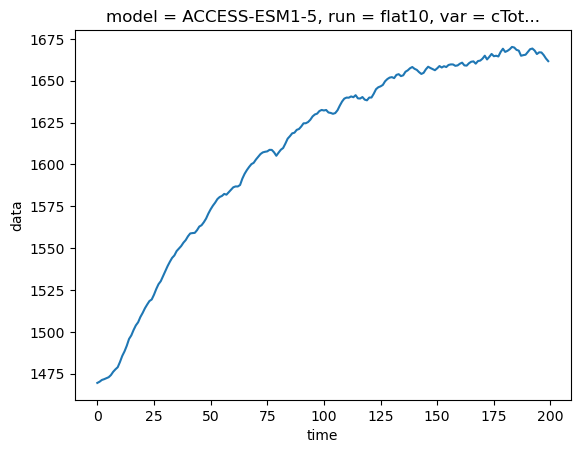

In [9]:
# to load data from this ds

# Access data for one model, run, var
#subset = ds.sel(time=0.1, model='model1', run='run1', var='var1')

subset = ds_C_global.sel(model=modellist[0], run=runlist[0], var='cTot', latrange='global')

print(subset)

subset.data[0:200].plot()

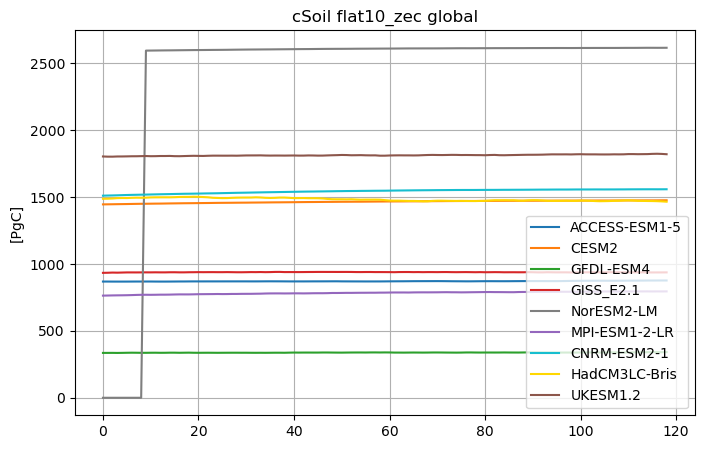

In [10]:
fig = plt.figure(figsize=(8,5))

e=1
v=1
l=0
for m in range(len(modellist)):
    mcolor=modelcolors[m]
    timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], var=varlist[v], latrange=latlist[l])
    
    plt.plot(timeseries.data[1:120].values,label=modellist[m],color=mcolor)

plt.title(varlist[v] +' ' +runlist[e] +' ' +latlist[l])# +modellist[0] 
plt.ylabel('[PgC]')
plt.legend()
plt.grid()

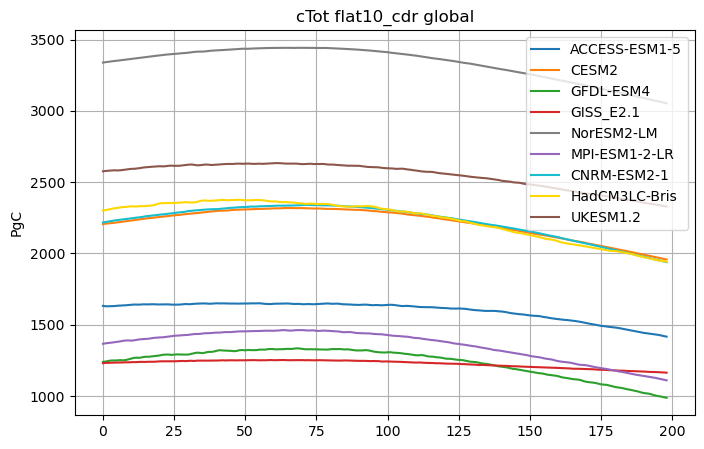

In [11]:
fig = plt.figure(figsize=(8,5))

e=2
v=2
l=0
for m in range(len(modellist)):
    mcolor=modelcolors[m]
    timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], var=varlist[v], latrange=latlist[l])
    
    plt.plot(timeseries.data[1:200].values,label=modellist[m],color=mcolor)

plt.title(varlist[v] +' ' +runlist[e] +' ' +latlist[l])# +modellist[0] 
plt.ylabel('PgC')
plt.legend()
plt.grid()

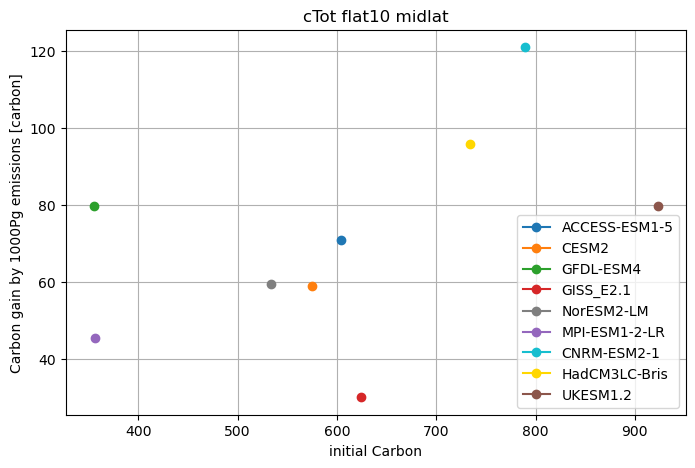

In [12]:
fig = plt.figure(figsize=(8,5))


e=0
v=2
l=3
for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]
    timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], var=varlist[v], latrange=latlist[l])
    initC=np.mean(timeseries.data[0:9])
    nzC=np.mean(timeseries.data[90:109])
    plt.plot(initC,nzC-initC,marker='o',label=model,color=mcolor)


plt.title(varlist[v] +' ' +runlist[e] +' ' +latlist[l])
plt.ylabel('Carbon gain by 1000Pg emissions [carbon]')
plt.xlabel('initial Carbon')
plt.legend()
plt.grid()

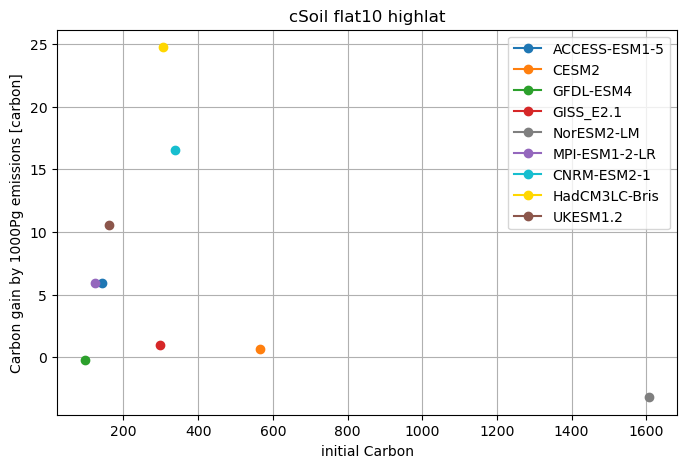

In [13]:
fig = plt.figure(figsize=(8,5))


e=0
v=1
l=1
for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]
    timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], var=varlist[v], latrange=latlist[l])
    initC=np.mean(timeseries.data[0:9])
    nzC=np.mean(timeseries.data[90:109])
    plt.plot(initC,nzC-initC,marker='o',label=model,color=mcolor)


plt.title(varlist[v] +' ' +runlist[e] +' ' +latlist[l])
plt.ylabel('Carbon gain by 1000Pg emissions [carbon]')
plt.xlabel('initial Carbon')
plt.legend()
plt.grid()

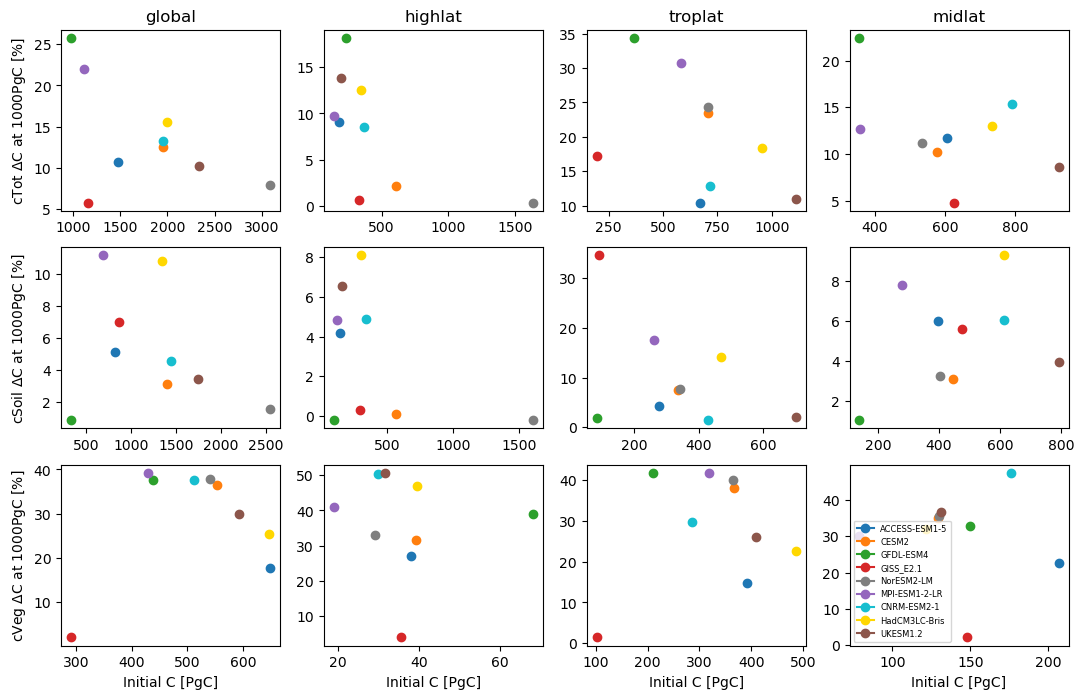

In [14]:
fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are % change
vlist = [2,1,0]
e=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[90:109])
            axes[vi,l].plot(initC,100*(nzC-initC)/initC,marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('Initial C [PgC]')
axes[2,1].set_xlabel('Initial C [PgC]')
axes[2,2].set_xlabel('Initial C [PgC]')
axes[2,3].set_xlabel('Initial C [PgC]')

axes[0,0].set_ylabel(varlist[vlist[0]] +' $\Delta$C at 1000PgC [%]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' $\Delta$C at 1000PgC [%]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' $\Delta$C at 1000PgC [%]')
#axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

# add grid lines after all models are plotted
for i in range(3):
    for j in range(4):
        axes[i,j].grid()
        
axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscatter_pct.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatter_pct.jpg", bbox_inches='tight')


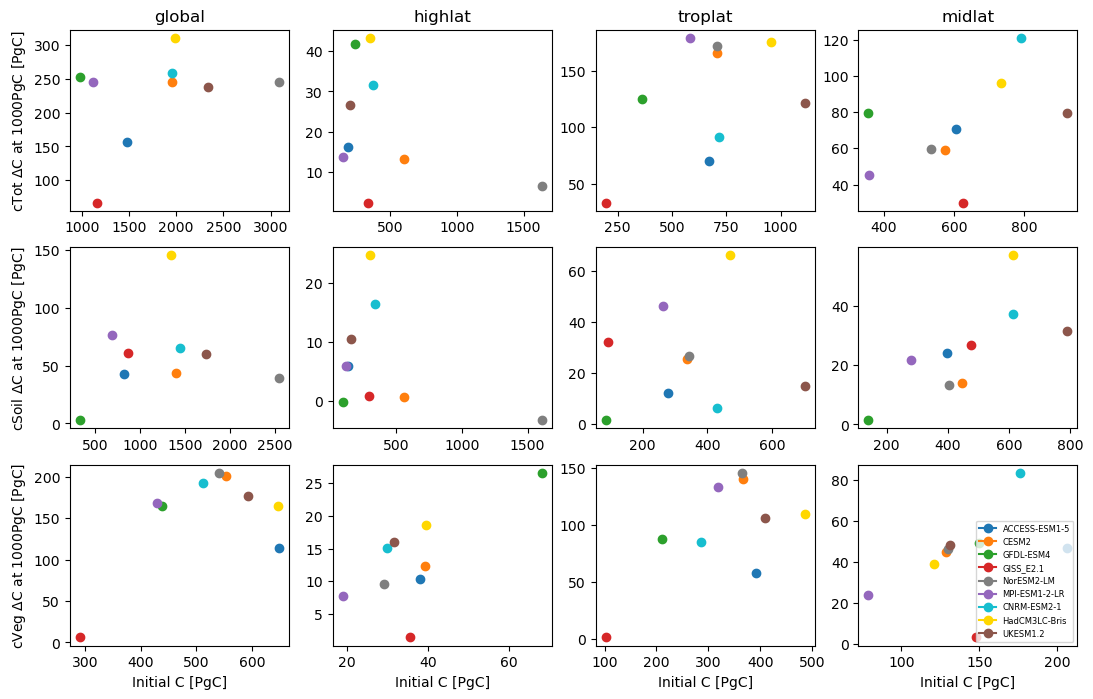

In [15]:
fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change
vlist = [2,1,0]
e=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[90:109])
            axes[vi,l].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('Initial C [PgC]')
axes[2,1].set_xlabel('Initial C [PgC]')
axes[2,2].set_xlabel('Initial C [PgC]')
axes[2,3].set_xlabel('Initial C [PgC]')

axes[0,0].set_ylabel(varlist[vlist[0]] +' $\Delta$C at 1000PgC [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' $\Delta$C at 1000PgC [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' $\Delta$C at 1000PgC [PgC]')
#axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

# add grid lines after all models are plotted
for i in range(3):
    for j in range(4):
        axes[i,j].grid()

axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscatter_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatter_PgC.jpg", bbox_inches='tight')


### Bar plots

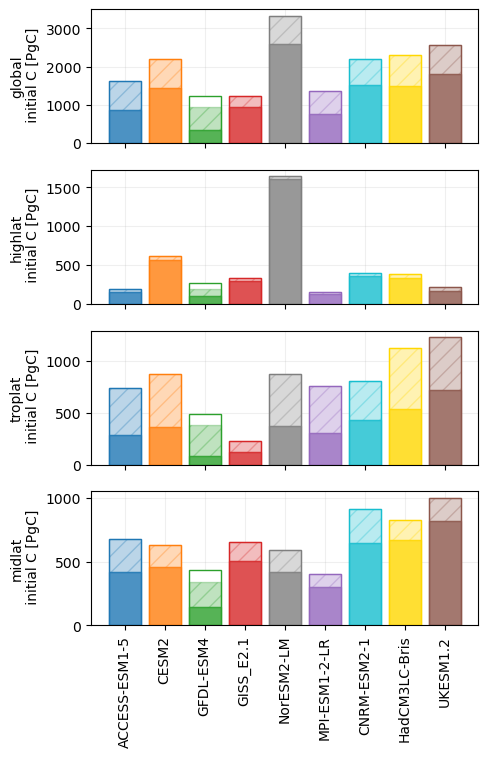

In [16]:
fig, axes = plt.subplots(4,1,figsize=(5, 8))
#axes=axes.flatten()

# one column 
# one row for each region (global, midlat, tropical, highlat)
#array(['cVeg', 'cSoil', 'cTot'])
vlist = [2,1,0]
e=0

hatchlist=['//','','']
alphalist=[0.3,0.8,1]

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    
    for l in range(len(latlist)):
        # total
        vi=2
        v=2 #vlist[vi]
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        nzC=np.mean(timeseries.data[90:109])
        sbar=(nzC)
        #plot
        axes[l].bar(m, sbar, hatch=hatchlist[vi],label=model,color='white',
                    alpha=alphalist[vi],edgecolor=mcolor)


        # soil (bottom)
        vi=1
        v=1 #vlist[vi]
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        nzC=np.mean(timeseries.data[90:109])
        sbar=(nzC)
        soilbar=sbar
        # plot bar
        axes[l].bar(m, sbar, hatch=hatchlist[vi],label=model,color=mcolor,
                    alpha=alphalist[vi],edgecolor=mcolor)
        
        # vegetation
        vi=0
        v=0#vlist[vi]
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        nzC=np.mean(timeseries.data[90:109])
        sbar=(nzC)
        #plot
        axes[l].bar(m, sbar, bottom=soilbar, hatch=hatchlist[vi],label=model,color=mcolor,alpha=alphalist[vi],edgecolor=mcolor)


 

axes[0].xaxis.set_tick_params(labelcolor='none')
axes[1].xaxis.set_tick_params(labelcolor='none')
axes[2].xaxis.set_tick_params(labelcolor='none')
axes[3].set_xticks(np.arange(len(modellist)), modellist,rotation='vertical')

axes[0].set_ylabel(latlist[0] +'\n initial C [PgC]')
axes[1].set_ylabel(latlist[1] +'\n initial C [PgC]')
axes[2].set_ylabel(latlist[2] +'\n initial C [PgC]')
axes[3].set_ylabel(latlist[3] +'\n initial C [PgC]')


# add grid lines after all models are plotted
axes[0].set_axisbelow(True)
axes[0].grid(alpha=0.2)

axes[1].set_axisbelow(True)
axes[1].grid(alpha=0.2)

axes[2].set_axisbelow(True)
axes[2].grid(alpha=0.2)

axes[3].set_axisbelow(True)
axes[3].grid(alpha=0.2)


#axes[2,3].legend(fontsize=6)

#plt.show()
plt.savefig("figures/bar_initC_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/bar_initC_PgC.png", bbox_inches='tight')
#plt.close()

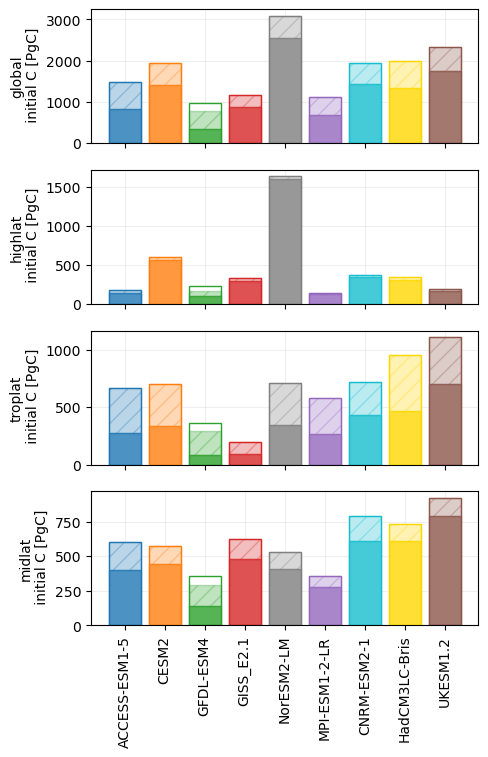

In [17]:
# Normalized to sum to 1


fig, axes = plt.subplots(4,1,figsize=(5, 8))
#axes=axes.flatten()

# one column 
# one row for each region (global, midlat, tropical, highlat)
#array(['cVeg', 'cSoil', 'cTot'])
vlist = [2,1,0]
e=0

hatchlist=['//','','']
alphalist=[0.3,0.8,1]

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    
    for l in range(len(latlist)):
        # total
        vi=2
        v=2 #vlist[vi]
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        nzC=np.mean(timeseries.data[90:109])
        sbar=(initC)
        #plot
        axes[l].bar(m, sbar, hatch=hatchlist[vi],label=model,color='white',
                    alpha=alphalist[vi],edgecolor=mcolor)


        # soil (bottom)
        vi=1
        v=1 #vlist[vi]
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        nzC=np.mean(timeseries.data[90:109])
        sbar=(initC)
        soilbar=sbar
        # plot bar
        axes[l].bar(m, sbar, hatch=hatchlist[vi],label=model,color=mcolor,
                    alpha=alphalist[vi],edgecolor=mcolor)
        
        # vegetation
        vi=0
        v=0#vlist[vi]
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        nzC=np.mean(timeseries.data[90:109])
        sbar=(initC)
        #plot
        axes[l].bar(m, sbar, bottom=soilbar, hatch=hatchlist[vi],label=model,color=mcolor,alpha=alphalist[vi],edgecolor=mcolor)


 

axes[0].xaxis.set_tick_params(labelcolor='none')
axes[1].xaxis.set_tick_params(labelcolor='none')
axes[2].xaxis.set_tick_params(labelcolor='none')
axes[3].set_xticks(np.arange(len(modellist)), modellist,rotation='vertical')

axes[0].set_ylabel(latlist[0] +'\n initial C [PgC]')
axes[1].set_ylabel(latlist[1] +'\n initial C [PgC]')
axes[2].set_ylabel(latlist[2] +'\n initial C [PgC]')
axes[3].set_ylabel(latlist[3] +'\n initial C [PgC]')


# add grid lines after all models are plotted
axes[0].set_axisbelow(True)
axes[0].grid(alpha=0.2)

axes[1].set_axisbelow(True)
axes[1].grid(alpha=0.2)

axes[2].set_axisbelow(True)
axes[2].grid(alpha=0.2)

axes[3].set_axisbelow(True)
axes[3].grid(alpha=0.2)


#axes[2,3].legend(fontsize=6)

#plt.show()
#plt.savefig("figures/bar_initC_PgC.pdf", bbox_inches='tight')
#plt.savefig("figures/bar_initC_PgC.png", bbox_inches='tight')
#plt.close()

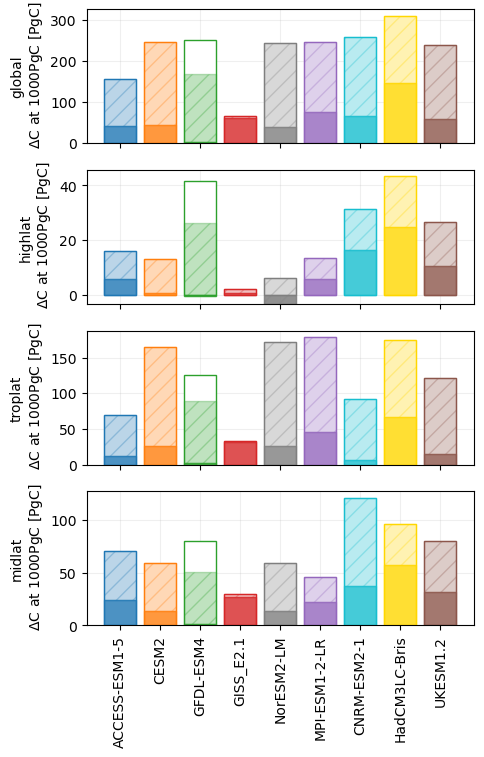

In [18]:
fig, axes = plt.subplots(4,1,figsize=(5, 8))
#axes=axes.flatten()

# one column 
# one row for each region (global, midlat, tropical, highlat)
#array(['cVeg', 'cSoil', 'cTot'])
vlist = [2,1,0]
e=0

hatchlist=['//','','']
alphalist=[0.3,0.8,1]

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    
    for l in range(len(latlist)):
        # total
        vi=2
        v=2 #vlist[vi]
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        nzC=np.mean(timeseries.data[90:109])
        sbar=(nzC-initC)
        #plot
        axes[l].bar(m, sbar, hatch=hatchlist[vi],label=model,color='white',
                    alpha=alphalist[vi],edgecolor=mcolor)


        # soil (bottom)
        vi=1
        v=1 #vlist[vi]
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        nzC=np.mean(timeseries.data[90:109])
        sbar=(nzC-initC)
        soilbar=sbar
        # plot bar
        axes[l].bar(m, sbar, hatch=hatchlist[vi],label=model,color=mcolor,
                    alpha=alphalist[vi],edgecolor=mcolor)
        
        # vegetation
        vi=0
        v=0#vlist[vi]
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        nzC=np.mean(timeseries.data[90:109])
        sbar=(nzC-initC)
        #plot
        axes[l].bar(m, sbar, bottom=soilbar, hatch=hatchlist[vi],label=model,color=mcolor,alpha=alphalist[vi],edgecolor=mcolor)


 

axes[0].xaxis.set_tick_params(labelcolor='none')
axes[1].xaxis.set_tick_params(labelcolor='none')
axes[2].xaxis.set_tick_params(labelcolor='none')
axes[3].set_xticks(np.arange(len(modellist)), modellist,rotation='vertical')

axes[0].set_ylabel(latlist[0] +'\n $\Delta$C at 1000PgC [PgC]')
axes[1].set_ylabel(latlist[1] +'\n $\Delta$C at 1000PgC [PgC]')
axes[2].set_ylabel(latlist[2] +'\n $\Delta$C at 1000PgC [PgC]')
axes[3].set_ylabel(latlist[3] +'\n $\Delta$C at 1000PgC [PgC]')


# add grid lines after all models are plotted
axes[0].set_axisbelow(True)
axes[0].grid(alpha=0.2)

axes[1].set_axisbelow(True)
axes[1].grid(alpha=0.2)

axes[2].set_axisbelow(True)
axes[2].grid(alpha=0.2)

axes[3].set_axisbelow(True)
axes[3].grid(alpha=0.2)


#axes[2,3].legend(fontsize=6)

#plt.show()
plt.savefig("figures/bar_emissionsphase_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/bar_emissionsphase_PgC.png", bbox_inches='tight')
#plt.close()

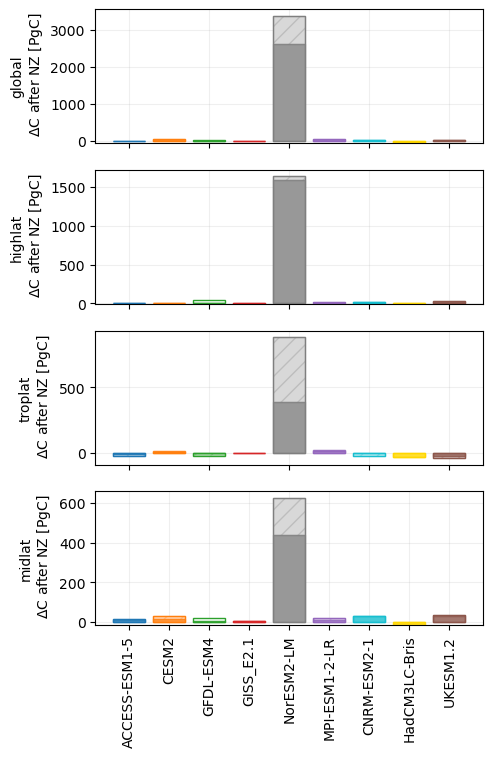

In [19]:
fig, axes = plt.subplots(4,1,figsize=(5, 8))
#axes=axes.flatten()

# one column 
# one row for each region (global, midlat, tropical, highlat)
#array(['cVeg', 'cSoil', 'cTot'])
vlist = [0,1,2]
e=0

hatchlist=['//','','']
alphalist=[0.3,0.8,1]

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]



            # timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
            #                                var=varlist[v], latrange=latlist[l])
            # initC=np.mean(timeseries.data[0:9])
            
            # e=2
            # timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
            #                                var=varlist[v], latrange=latlist[l])
            
            # nzC=np.mean(timeseries.data[190:199])
            # axes[vi,l].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)

    for l in range(len(latlist)):
        # total
        vi=2
        v=2 #vlist[vi]
        #e=0
        #timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
        #                           var=varlist[v], latrange=latlist[l])
        #initC=np.mean(timeseries.data[0:9])
        e=1
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        nzC=np.mean(timeseries.data[190:199])
        sbar=(nzC-initC)
        #plot
        axes[l].bar(m, sbar, hatch=hatchlist[vi],label=model,color='white',alpha=alphalist[vi],edgecolor=mcolor)


        # soil (bottom)
        vi=1
        v=1 #vlist[vi]
        #e=0
        #timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
        #                           var=varlist[v], latrange=latlist[l])
        #initC=np.mean(timeseries.data[0:9])
        e=1
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        nzC=np.mean(timeseries.data[190:199])
        sbar=(nzC-initC)
        soilbar=sbar
        # plot bar
        axes[l].bar(m, sbar, hatch=hatchlist[vi],label=model,color=mcolor,alpha=alphalist[vi],edgecolor=mcolor)
        
        # vegetation
        vi=0
        v=0 #vlist[vi]
        #e=0
        #timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
        #                           var=varlist[v], latrange=latlist[l])
        
        e=1
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        nzC=np.mean(timeseries.data[190:199])
        sbar=(nzC-initC)
        #plot
        #if sbar>0:
        #    axes[l].bar(m, sbar, bottom=np.max([soilbar.values,0]), hatch=hatchlist[vi],label=model,color=mcolor,alpha=alphalist[vi],edgecolor='black')
        #else:
        #    axes[l].bar(m, sbar, bottom=np.min([soilbar.values,0]), hatch=hatchlist[vi],label=model,color=mcolor,alpha=alphalist[vi],edgecolor='black')

        axes[l].bar(m, sbar, bottom=soilbar, hatch=hatchlist[vi],label=model,color=mcolor,alpha=alphalist[vi],edgecolor=mcolor)
              

 

axes[0].xaxis.set_tick_params(labelcolor='none')
axes[1].xaxis.set_tick_params(labelcolor='none')
axes[2].xaxis.set_tick_params(labelcolor='none')
axes[3].set_xticks(np.arange(len(modellist)), modellist,rotation='vertical')

axes[0].set_ylabel(latlist[0] +'\n $\Delta$C after NZ [PgC]')
axes[1].set_ylabel(latlist[1] +'\n $\Delta$C after NZ [PgC]')
axes[2].set_ylabel(latlist[2] +'\n $\Delta$C after NZ [PgC]')
axes[3].set_ylabel(latlist[3] +'\n $\Delta$C after NZ [PgC]')


# add grid lines after all models are plotted
axes[0].set_axisbelow(True)
axes[0].grid(alpha=0.2)

axes[1].set_axisbelow(True)
axes[1].grid(alpha=0.2)

axes[2].set_axisbelow(True)
axes[2].grid(alpha=0.2)

axes[3].set_axisbelow(True)
axes[3].grid(alpha=0.2)


#axes[2,3].legend(fontsize=6)

#plt.show()
plt.savefig("figures/bar_NZ_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/bar_NZ_PgC.png", bbox_inches='tight')
#plt.close()

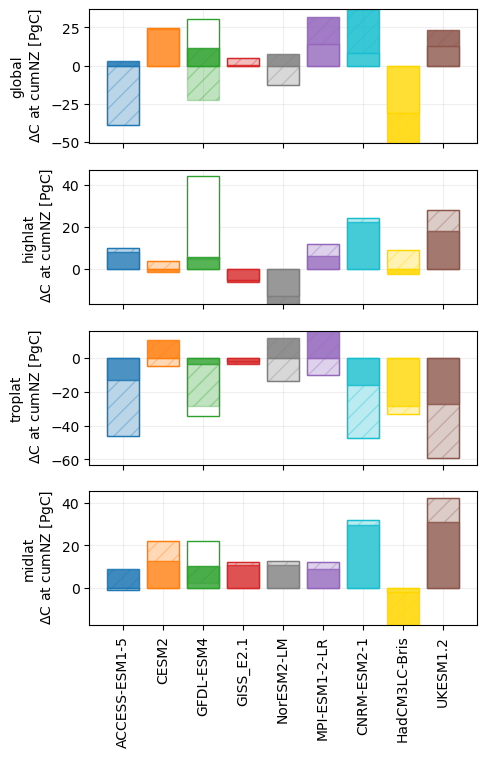

In [20]:
fig, axes = plt.subplots(4,1,figsize=(5, 8))
#axes=axes.flatten()

# one column 
# one row for each region (global, midlat, tropical, highlat)
#array(['cVeg', 'cSoil', 'cTot'])
vlist = [0,1,2]
e=0

hatchlist=['//','','']
alphalist=[0.3,0.8,1]

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]



            # timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
            #                                var=varlist[v], latrange=latlist[l])
            # initC=np.mean(timeseries.data[0:9])
            
            # e=2
            # timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
            #                                var=varlist[v], latrange=latlist[l])
            
            # nzC=np.mean(timeseries.data[190:199])
            # axes[vi,l].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)

    for l in range(len(latlist)):
        # total
        vi=2
        v=2 #vlist[vi]
        e=0
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        e=2
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
        nzC=np.mean(timeseries.data[190:199])
        sbar=(nzC-initC)
        #plot
        axes[l].bar(m, sbar, hatch=hatchlist[vi],label=model,color='white',alpha=alphalist[vi],edgecolor=mcolor)


        # soil (bottom)
        vi=1
        v=1 #vlist[vi]
        e=0
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        e=2
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
        nzC=np.mean(timeseries.data[190:199])
        sbar=(nzC-initC)
        soilbar=sbar
        # plot bar
        axes[l].bar(m, sbar, hatch=hatchlist[vi],label=model,color=mcolor,alpha=alphalist[vi],edgecolor=mcolor)
        
        # vegetation
        vi=0
        v=0 #vlist[vi]
        e=0
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        e=2
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
        nzC=np.mean(timeseries.data[190:199])
        sbar=(nzC-initC)
        #plot
        #if sbar>0:
        #    axes[l].bar(m, sbar, bottom=np.max([soilbar.values,0]), hatch=hatchlist[vi],label=model,color=mcolor,alpha=alphalist[vi],edgecolor='black')
        #else:
        #    axes[l].bar(m, sbar, bottom=np.min([soilbar.values,0]), hatch=hatchlist[vi],label=model,color=mcolor,alpha=alphalist[vi],edgecolor='black')

        axes[l].bar(m, sbar, bottom=soilbar, hatch=hatchlist[vi],label=model,color=mcolor,alpha=alphalist[vi],edgecolor=mcolor)
              

 

axes[0].xaxis.set_tick_params(labelcolor='none')
axes[1].xaxis.set_tick_params(labelcolor='none')
axes[2].xaxis.set_tick_params(labelcolor='none')
axes[3].set_xticks(np.arange(len(modellist)), modellist,rotation='vertical')

axes[0].set_ylabel(latlist[0] +'\n $\Delta$C at cumNZ [PgC]')
axes[1].set_ylabel(latlist[1] +'\n $\Delta$C at cumNZ [PgC]')
axes[2].set_ylabel(latlist[2] +'\n $\Delta$C at cumNZ [PgC]')
axes[3].set_ylabel(latlist[3] +'\n $\Delta$C at cumNZ [PgC]')


# add grid lines after all models are plotted
axes[0].set_axisbelow(True)
axes[0].grid(alpha=0.2)

axes[1].set_axisbelow(True)
axes[1].grid(alpha=0.2)

axes[2].set_axisbelow(True)
axes[2].grid(alpha=0.2)

axes[3].set_axisbelow(True)
axes[3].grid(alpha=0.2)


#axes[2,3].legend(fontsize=6)

#plt.show()
plt.savefig("figures/bar_reversibility_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/bar_reversibility_PgC.png", bbox_inches='tight')
#plt.close()

In [21]:
np.max([soilbar.values, 30])

30.904974930046706

In [22]:
timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=varlist[v], latrange=latlist[l])
initC=np.mean(timeseries.data[0:9])
nzC=np.mean(timeseries.data[90:109])
sbar=(nzC-initC)


sbar

<xarray.DataArray 'data' ()> Size: 8B
array(10.22779295)
Coordinates:
    model     <U13 52B 'UKESM1.2'
    run       <U10 40B 'flat10_cdr'
    var       <U7 28B 'cVeg'
    latrange  <U7 28B 'midlat'

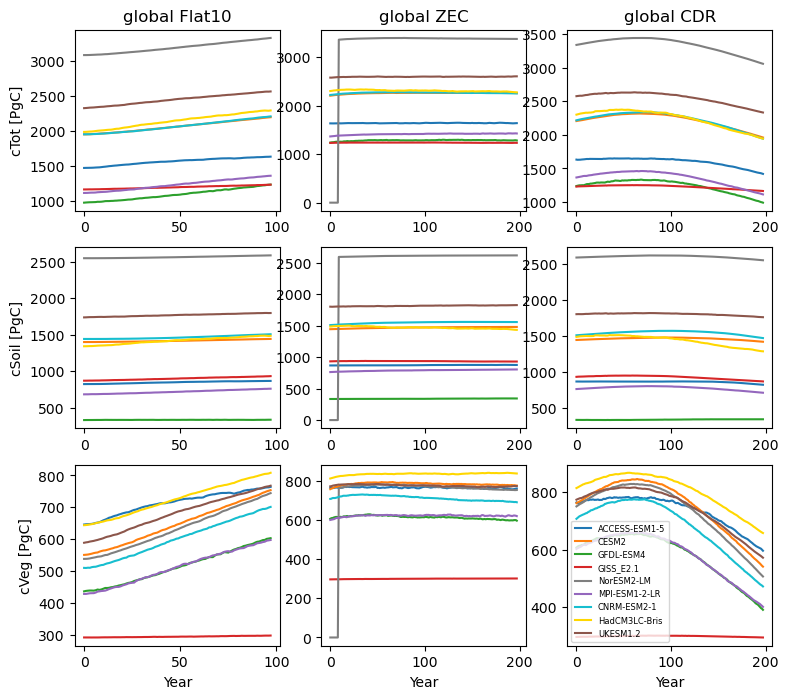

In [23]:
fig, axes = plt.subplots(3,3,figsize=(9, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
l=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        e=0
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        Cts=timeseries.data[1:99]
        axes[vi,0].plot(Cts,label=model,color=mcolor)

        e=1
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        Cts=timeseries.data[1:199]
        axes[vi,1].plot(Cts,label=model,color=mcolor)

        e=2
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        Cts=timeseries.data[1:199]
        axes[vi,2].plot(Cts,label=model,color=mcolor)



axes[0,0].set_title(latlist[l] +' Flat10')
axes[0,1].set_title(latlist[l] +' ZEC')
axes[0,2].set_title(latlist[l] +' CDR')


axes[2,0].set_xlabel('Year')
axes[2,1].set_xlabel('Year')
axes[2,2].set_xlabel('Year')

axes[0,0].set_ylabel(varlist[vlist[0]] +' [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' [PgC]')
#axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')


axes[2,2].legend(fontsize=6)

plt.savefig("figures/Ctimeseries_" +latlist[l] +"_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/Ctimeseries_" +latlist[l] +"_PgC.png", bbox_inches='tight')


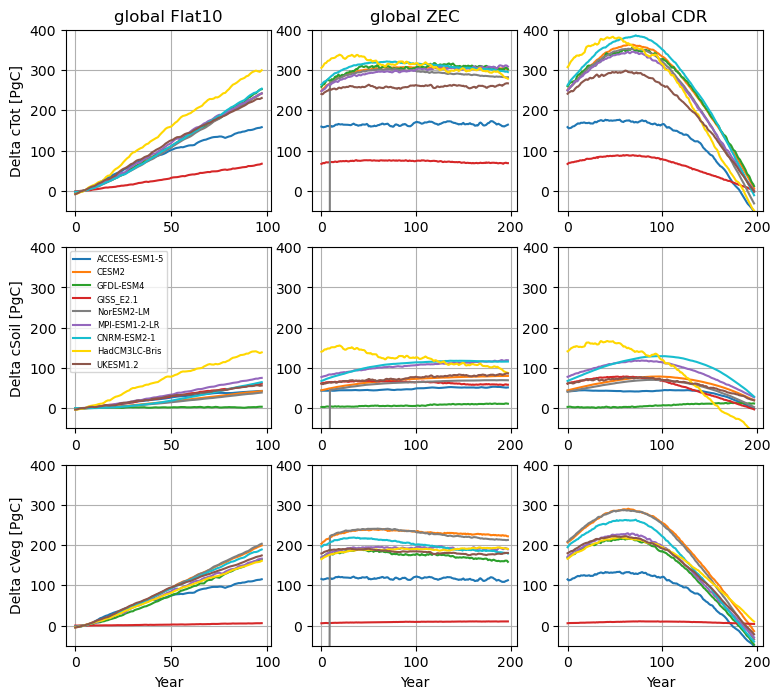

In [24]:
# normalized by initial carbon content

fig, axes = plt.subplots(3,3,figsize=(9, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
l=0

ymin=-50
ymax=400

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        e=0
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])

        initC=timeseries.data[1:10].mean()
        
        Cts=timeseries.data[1:99] - initC
        axes[vi,0].plot(Cts,label=model,color=mcolor)
        axes[vi,0].grid()
        axes[vi,0].set_ylim([ymin,ymax])

        e=1
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        Cts=timeseries.data[1:199]-initC
        axes[vi,1].plot(Cts,label=model,color=mcolor)
        axes[vi,1].grid()
        axes[vi,1].set_ylim([ymin,ymax])

        e=2
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        Cts=timeseries.data[1:199]-initC
        axes[vi,2].plot(Cts,label=model,color=mcolor)
        axes[vi,2].grid()
        axes[vi,2].set_ylim([ymin,ymax])


axes[0,0].set_title(latlist[l] +' Flat10')
axes[0,1].set_title(latlist[l] +' ZEC')
axes[0,2].set_title(latlist[l] +' CDR')


axes[2,0].set_xlabel('Year')
axes[2,1].set_xlabel('Year')
axes[2,2].set_xlabel('Year')

axes[0,0].set_ylabel('Delta ' +varlist[vlist[0]] +' [PgC]')
axes[1,0].set_ylabel('Delta ' +varlist[vlist[1]] +' [PgC]')
axes[2,0].set_ylabel('Delta ' +varlist[vlist[2]] +' [PgC]')
#axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

# ylimits


axes[1,0].legend(fontsize=6)

plt.savefig("figures/CtimeseriesDelta_" +latlist[l] +"_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/CtimeseriesDelta_" +latlist[l] +"_PgC.png", bbox_inches='tight')


In [25]:
arg=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values)-initC.values
#arg

NameError: name 'timeseriesE' is not defined

In [ ]:
#  continuous time series

fig, axes = plt.subplots(3,2,figsize=(12, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
l=0


for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        e=0
        timeseriesE=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        e=1
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        
        Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) 

        
        axes[vi,0].plot(Cts,label=model,color=mcolor)
        axes[vi,0].grid()
        axes[vi,0].plot([100,100],[-100,4000],color='black',linestyle=':')

        e=2
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        
        Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values)
        
        
        #Cts=timeseries.data[1:199]-initC
        axes[vi,1].plot(Cts,label=model,color=mcolor)
        axes[vi,1].grid()
        axes[vi,1].plot([100,100],[-100,4000],color='black',linestyle=':')
        
        


axes[0,0].set_title(latlist[l] +' Flat10 ZEC')
axes[0,1].set_title(latlist[l] +' Flat10 CDR')


axes[2,0].set_xlabel('Year')
axes[2,1].set_xlabel('Year')

axes[0,0].set_ylabel('Delta ' +varlist[vlist[0]] +' [PgC]')
axes[1,0].set_ylabel('Delta ' +varlist[vlist[1]] +' [PgC]')
axes[2,0].set_ylabel('Delta ' +varlist[vlist[2]] +' [PgC]')

# ylimits
axes[0,0].set_ylim([800,4000])
axes[0,1].set_ylim([800,4000])

axes[1,0].set_ylim([0,2700])
axes[1,1].set_ylim([0,2700])

axes[2,0].set_ylim([200,1000])
axes[2,1].set_ylim([200,1000])


axes[1,0].legend(fontsize=6)

plt.savefig("figures/Ctimeseries_contiuous_" +latlist[l] +"_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/Ctimeseries_contiuous_" +latlist[l] +"_PgC.png", bbox_inches='tight')


In [ ]:
# normalized by initial carbon content, and continuous time series

fig, axes = plt.subplots(3,2,figsize=(12, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
l=0


for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        e=0
        timeseriesE=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        initC=timeseriesE.data[1:10].mean()

        e=1
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        
        Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values

        
        axes[vi,0].plot(Cts,label=model,color=mcolor)
        axes[vi,0].grid()
        axes[vi,0].plot([100,100],[-100,400],color='black',linestyle=':')

        e=2
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        
        Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values
        
        
        #Cts=timeseries.data[1:199]-initC
        axes[vi,1].plot(Cts,label=model,color=mcolor)
        axes[vi,1].grid()
        axes[vi,1].plot([100,100],[-100,400],color='black',linestyle=':')
        
        


axes[0,0].set_title(latlist[l] +' Flat10 ZEC')
axes[0,1].set_title(latlist[l] +' Flat10 CDR')


axes[2,0].set_xlabel('Year')
axes[2,1].set_xlabel('Year')

axes[0,0].set_ylabel('Delta ' +varlist[vlist[0]] +' [PgC]')
axes[1,0].set_ylabel('Delta ' +varlist[vlist[1]] +' [PgC]')
axes[2,0].set_ylabel('Delta ' +varlist[vlist[2]] +' [PgC]')

# ylimits
axes[0,0].set_ylim([-50,400])
axes[0,1].set_ylim([-50,400])

axes[1,0].set_ylim([-75,200])
axes[1,1].set_ylim([-75,200])

axes[2,0].set_ylim([-50,300])
axes[2,1].set_ylim([-50,300])


axes[1,0].legend(fontsize=6)

plt.savefig("figures/CtimeseriesDelta_contiuous_" +latlist[l] +"_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/CtimeseriesDelta_contiuous_" +latlist[l] +"_PgC.png", bbox_inches='tight')


In [ ]:
# loop over all latitude bands
for l in range(len(latlist)):

    fig, axes = plt.subplots(3,3,figsize=(9, 8))
    #axes=axes.flatten()
    
    # rows are carbon variables, cTot, cVeg, cSoil
    # columns are total change, % change
    vlist = [2,1,0]
    
    for m in range(len(modellist)):
        model=modellist[m]
        mcolor=modelcolors[m]
    
        for vi in range(len(vlist)):
            v=vlist[vi]
            e=0
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            Cts=timeseries.data[1:99]
            axes[vi,0].plot(Cts,label=model,color=mcolor)
    
            e=1
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            Cts=timeseries.data[1:199]
            axes[vi,1].plot(Cts,label=model,color=mcolor)
    
            e=2
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            Cts=timeseries.data[1:199]
            axes[vi,2].plot(Cts,label=model,color=mcolor)
    
    
    
    axes[0,0].set_title(latlist[l] +' Flat10')
    axes[0,1].set_title(latlist[l] +' ZEC')
    axes[0,2].set_title(latlist[l] +' CDR')
    
    
    axes[2,0].set_xlabel('Year')
    axes[2,1].set_xlabel('Year')
    axes[2,2].set_xlabel('Year')
    
    axes[0,0].set_ylabel(varlist[vlist[0]] +' [PgC]')
    axes[1,0].set_ylabel(varlist[vlist[1]] +' [PgC]')
    axes[2,0].set_ylabel(varlist[vlist[2]] +' [PgC]')
    #axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')
    
    axes[2,2].legend(fontsize=6)
    
    plt.savefig("figures/Ctimeseries_" +latlist[l] +"_PgC.pdf", bbox_inches='tight')
    plt.savefig("figures/Ctimeseries_" +latlist[l] +"_PgC.png", bbox_inches='tight')


In [ ]:
# loop over all latitude bands
for l in range(len(latlist)):

    # normalized by initial carbon content, and continuous time series
    
    fig, axes = plt.subplots(3,2,figsize=(12, 8))
    #axes=axes.flatten()
    
    # rows are carbon variables, cTot, cVeg, cSoil
    # columns are total change, % change
    vlist = [2,1,0]
    
    
    for m in range(len(modellist)):
        model=modellist[m]
        mcolor=modelcolors[m]
    
        for vi in range(len(vlist)):
            v=vlist[vi]
            e=0
            timeseriesE=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initC=timeseriesE.data[1:10].mean()
    
            e=1
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            
            Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values
    
            
            axes[vi,0].plot(Cts,label=model,color=mcolor)
            axes[vi,0].grid()
            axes[vi,0].plot([100,100],[-100,400],color='black',linestyle=':')
    
            e=2
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            
            Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values
            
            
            #Cts=timeseries.data[1:199]-initC
            axes[vi,1].plot(Cts,label=model,color=mcolor)
            axes[vi,1].grid()
            axes[vi,1].plot([100,100],[-100,400],color='black',linestyle=':')
            
            
    
    
    axes[0,0].set_title(latlist[l] +' Flat10 ZEC')
    axes[0,1].set_title(latlist[l] +' Flat10 CDR')
    
    
    axes[2,0].set_xlabel('Year')
    axes[2,1].set_xlabel('Year')
    
    axes[0,0].set_ylabel('Delta ' +varlist[vlist[0]] +' [PgC]')
    axes[1,0].set_ylabel('Delta ' +varlist[vlist[1]] +' [PgC]')
    axes[2,0].set_ylabel('Delta ' +varlist[vlist[2]] +' [PgC]')
    
    # ylimits
    if l==0:
        axes[0,0].set_ylim([-50,400])
        axes[0,1].set_ylim([-50,400])
        
        axes[1,0].set_ylim([-75,200])
        axes[1,1].set_ylim([-75,200])
        
        axes[2,0].set_ylim([-50,300])
        axes[2,1].set_ylim([-50,300])
    elif l==1:
        axes[0,0].set_ylim([-25,100])
        axes[0,1].set_ylim([-25,100])
        
        axes[1,0].set_ylim([-25,50])
        axes[1,1].set_ylim([-25,50])
        
        axes[2,0].set_ylim([-25,50])
        axes[2,1].set_ylim([-25,50])
    elif l==2:
        axes[0,0].set_ylim([-50,300])
        axes[0,1].set_ylim([-50,300])
        
        axes[1,0].set_ylim([-50,100])
        axes[1,1].set_ylim([-50,100])
        
        axes[2,0].set_ylim([-50,200])
        axes[2,1].set_ylim([-50,200])
    elif l==3:
        axes[0,0].set_ylim([-25,210])
        axes[0,1].set_ylim([-25,210])
        
        axes[1,0].set_ylim([-25,100])
        axes[1,1].set_ylim([-25,100])
        
        axes[2,0].set_ylim([-25,150])
        axes[2,1].set_ylim([-25,150])
    
    
    axes[1,0].legend(fontsize=6)
    
    plt.savefig("figures/CtimeseriesDelta_contiuous_" +latlist[l] +"_PgC.pdf", bbox_inches='tight')
    plt.savefig("figures/CtimeseriesDelta_contiuous_" +latlist[l] +"_PgC.png", bbox_inches='tight')
    


### vegetation vs. soil sinks

vegetation and soil sinks are calculated from vegetation carbon and soil carbon

we want to know the initital stocks as well as the change over time under different experiemnts



### reversibility

reversibility is the state of the system after cumulative emissions reach zero in the flat10-cdr experiment

In [ ]:
### This is not working right becuase the cdr experiment for access has data problems

fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            e=0
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            
            e=2
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            
            nzC=np.mean(timeseries.data[190:199])
            axes[vi,l].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
            
            #axes[vi,l].grid() # this doesn't seem to work
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('Initial C [PgC]')
axes[2,1].set_xlabel('Initial C [PgC]')
axes[2,2].set_xlabel('Initial C [PgC]')
axes[2,3].set_xlabel('Initial C [PgC]')

axes[0,0].set_ylabel(varlist[vlist[0]] +' $\Delta$C at cumNZ [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' $\Delta$C at cumNZ [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' $\Delta$C at cumNZ [PgC]')
#axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

axes[2,3].legend(fontsize=6)

# add grid lines after all models are plotted
for i in range(3):
    for j in range(4):
        axes[i,j].grid()

plt.savefig("figures/deltaCscatter_PgC_cumNZ.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatter_PgC_cumNZ.jpg", bbox_inches='tight')


### timing of peak land sink

timing of peak land sink comes from the maximum in globally averaged cumulative land carbon sink in flat10-cdr experiment

### TCRE and ZEC 

TCRE is calcualted as the warming that occurs at year 100 in the flat10 experiment

ZEC is the change in warming after net-zero emissions, which is the temperature at a given time in the flat10-zec experiment minus the tempeature at year 100 in the flat10 experiment


These numbers are copied from Ben Sanderson's flat10 repository notebook. Not the best way to do this.

In [ ]:

esm_tcre_flat10= [1.75301063, 1.95146945, 1.45465386, 1.62163849, 1.17821122, 1.50077057, 1.72289277, 2.503865,   1.86102962, 2.02051318]
esm_zec50_flat10= [ 0.20830381, -0.2631313, -0.20984793, -0.18912964, -0.22547232, -0.13938904,  0.00142626,  0.272745,    0.059901,    0.0960024 ]
esm_zec90_flat10= [ 0.14918208, -0.13839814, -0.12847126, -0.14947052, -0.21317124, -0.16652226, 0.07068745,  0.18805,     0.10838604,  0.11575942]
esm_zec100_flat10= [0.13327324, -0.12651117, -0.1135391,  -0.24052734, -0.31327247, -0.2394135,  0.10518711, 0.20698,     0.1190201,   0.15074751]
esm_tpw_flat10= [  7., -10., -29., -4., -33.,   1., -10.,  -1.,   3.,  11.]
esm_tnz_flat10= [ 0.08160996,  0.05382003, -0.09170842,  0.12097321, -0.02551466, -0.06321108,  0.10861629,  0.162655,    0.07346749, -0.03127059]
esm_tr1000_flat10= [ 0.23198843,  0.029688,   -0.25358582,  0.01142578, -0.22908808, -0.23681939, 0.02917725,  0.48317,    0.19768906,  0.16988671]
esm_tr0_flat10= [ 0.17284241,  0.41951067, -0.1129776,  -0.56428833, -0.30888033, -0.29384002,  0.37563933,         np.nan,  0.25246087,  0.14777742]


print("TCRE:", esm_tcre_flat10)
print("ZEC50:", esm_zec50_flat10)
print("ZEC90:", esm_zec90_flat10)
print("ZEC100:", esm_zec100_flat10)
print("TPW:", esm_tpw_flat10)
print("TNZ:", esm_tnz_flat10)
print("TR1000:", esm_tr1000_flat10)
print("TR0:", esm_tr0_flat10)

esm_metrics_flat10 = pd.DataFrame({})
esm_metrics_flat10['tcre']=esm_tcre_flat10
esm_metrics_flat10['zec50']=esm_zec50_flat10
esm_metrics_flat10['zec90']=esm_zec100_flat10
esm_metrics_flat10['zec100']=esm_zec100_flat10
esm_metrics_flat10['tpw']=esm_tpw_flat10
esm_metrics_flat10['tnz']=esm_tnz_flat10
esm_metrics_flat10['tr1000']=esm_tr1000_flat10
esm_metrics_flat10['tr0']=esm_tr0_flat10

mdls=['ACCESS-ESM1-5','CESM2','GFDL-ESM4','GISS_E2.1','NorESM2-LM','MPI-ESM1-2-LR','CNRM-ESM2-1','UKESM1.2','UVic-ESCM-2-10','HadCM3LC-Bris']

esm_metrics_flat10.index=mdls


esm_metrics_flat10

In [ ]:
# alternatively (missing HadCM3)
## read TCRE and ZEC from Ben Sanderson's Flat10MIP paper folder

esm_metrics_flat10_bs=pd.read_csv('/glade/work/aswann/jupyter_notebooks/esm-deck/esm_metrics_flat10.csv')

In [ ]:
esm_metrics_flat10_bs

In [ ]:
## Our list of models is different from the full list, so make a subset of the data

il = [mdls.index(i) for i in modellist]
il

In [ ]:
esm_metrics_flat10_subset=esm_metrics_flat10['tcre'][il].values

esm_metrics_flat10_subset

In [ ]:

#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
e=0

for l in range(len(latlist)):  
    fig, axes = plt.subplots(3,3,figsize=(9, 8))
    for m in range(len(modellist)):
        model=modellist[m]
        mcolor=modelcolors[m]
    
        tcre= esm_metrics_flat10['tcre'][il].values
        zec50=esm_metrics_flat10['zec50'][il].values
        zec100=esm_metrics_flat10['zec100'][il].values
        
        
        for vi in range(len(vlist)):
            v=vlist[vi]
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[90:109])
            deltaC=nzC-initC
            axes[0,vi].plot(deltaC,tcre[m],marker='o',label=model,color=mcolor)
            axes[0,vi].grid()
        
            axes[1,vi].plot(deltaC,zec50[m],marker='o',label=model,color=mcolor)
            axes[1,vi].grid()
        
            axes[2,vi].plot(deltaC,zec100[m],marker='o',label=model,color=mcolor)
            axes[2,vi].grid() 
        
    
    
    
    axes[0,1].set_title('$\Delta$ C ' +latlist[l] +', emissions phase')
    #axes[0,1].set_title(varlist[vlist[1]])
    #axes[0,2].set_title(varlist[vlist[2]])
    
    
    
    axes[2,0].set_xlabel(varlist[vlist[0]] +' $\Delta$ C [PgC]')
    axes[2,1].set_xlabel(varlist[vlist[1]] +' $\Delta$ C [PgC]')
    axes[2,2].set_xlabel(varlist[vlist[2]] +' $\Delta$ C [PgC]')
    
    
    axes[0,0].set_ylabel('TCRE')
    axes[1,0].set_ylabel('ZEC50')
    axes[2,0].set_ylabel('ZEC100')
    #axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

    # add grid lines after all models are plotted
    for i in range(3):
        for j in range(3):
            axes[i,j].grid()
        
    axes[2,2].legend(fontsize=6)
    
    plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +"_emissionsphase.pdf", bbox_inches='tight')
    plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +"_emissionsphase.png", bbox_inches='tight')


In [ ]:

#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
e=1

for l in range(len(latlist)):  
    fig, axes = plt.subplots(3,3,figsize=(9, 8))
    for m in range(len(modellist)):
        model=modellist[m]
        mcolor=modelcolors[m]
    
        tcre= esm_metrics_flat10['tcre'][il].values
        zec50=esm_metrics_flat10['zec50'][il].values
        zec100=esm_metrics_flat10['zec100'][il].values
        
        
        for vi in range(len(vlist)):
            v=vlist[vi]
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[190:199])
            deltaC=nzC-initC
            axes[0,vi].plot(deltaC,tcre[m],marker='o',label=model,color=mcolor)
            axes[0,vi].grid()
        
            axes[1,vi].plot(deltaC,zec50[m],marker='o',label=model,color=mcolor)
            axes[1,vi].grid()
        
            axes[2,vi].plot(deltaC,zec100[m],marker='o',label=model,color=mcolor)
            axes[2,vi].grid() 
        
    
    
    
    axes[0,1].set_title('$\Delta$ C ' +latlist[l] +', Carbon lost during zero emissions')
    #axes[0,1].set_title(varlist[vlist[1]])
    #axes[0,2].set_title(varlist[vlist[2]])
    
    
    
    axes[2,0].set_xlabel(varlist[vlist[0]] +' $\Delta$ C [PgC]')
    axes[2,1].set_xlabel(varlist[vlist[1]] +' $\Delta$ C [PgC]')
    axes[2,2].set_xlabel(varlist[vlist[2]] +' $\Delta$ C [PgC]')
    
    
    axes[0,0].set_ylabel('TCRE')
    axes[1,0].set_ylabel('ZEC50')
    axes[2,0].set_ylabel('ZEC100')
    #axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

    # add grid lines after all models are plotted
    for i in range(3):
        for j in range(3):
            axes[i,j].grid()
            
    axes[2,2].legend(fontsize=6)
    
    plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +"_zeroemissions.pdf", bbox_inches='tight')
    plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +"_zeroemissions.png", bbox_inches='tight')


In [ ]:

#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
e=2

for l in range(len(latlist)):  
    fig, axes = plt.subplots(3,3,figsize=(9, 8))
    for m in range(len(modellist)):
        model=modellist[m]
        mcolor=modelcolors[m]
    
        tcre= esm_metrics_flat10['tcre'][il].values
        zec50=esm_metrics_flat10['zec50'][il].values
        zec100=esm_metrics_flat10['zec100'][il].values
        
        
        for vi in range(len(vlist)):
            v=vlist[vi]
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initialCtimeseries=ds_C_global.sel(model=modellist[m], run=runlist[0], 
                                           var=varlist[v], latrange=latlist[l])
            initC=np.mean(initialCtimeseries.data[0:9])
            nzC=np.mean(timeseries.data[190:199])
            deltaC=nzC-initC
            axes[0,vi].plot(deltaC,tcre[m],marker='o',label=model,color=mcolor)
            axes[0,vi].grid()
        
            axes[1,vi].plot(deltaC,zec50[m],marker='o',label=model,color=mcolor)
            axes[1,vi].grid()
        
            axes[2,vi].plot(deltaC,zec100[m],marker='o',label=model,color=mcolor)
            axes[2,vi].grid() 
        
    
    
    
    axes[0,1].set_title('$\Delta$ C ' +latlist[l] +', Carbon change at cumulative zero emissions')
    #axes[0,1].set_title(varlist[vlist[1]])
    #axes[0,2].set_title(varlist[vlist[2]])
    
    
    
    axes[2,0].set_xlabel(varlist[vlist[0]] +' $\Delta$ C [PgC]')
    axes[2,1].set_xlabel(varlist[vlist[1]] +' $\Delta$ C [PgC]')
    axes[2,2].set_xlabel(varlist[vlist[2]] +' $\Delta$ C [PgC]')
    
    
    axes[0,0].set_ylabel('TCRE')
    axes[1,0].set_ylabel('ZEC50')
    axes[2,0].set_ylabel('ZEC100')
    #axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

    # add grid lines after all models are plotted
    for i in range(3):
        for j in range(3):
            axes[i,j].grid()
            
    axes[2,2].legend(fontsize=6)
    
    plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +"_CumZeroemissions.pdf", bbox_inches='tight')
    plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +"_CumZeroemissions.png", bbox_inches='tight')


In [ ]:
# data from Arora 2020 for beta and gamma

#arora_beta = [0.75, 0.98, 1.37, 1.08, 1.08, 0.94,  1.]
#arora_gamma = [-12.,  -12.76,  -44.51,  -0.81,  -50.69,  -15.61,  -24.01]
#arora_models= ['ACCESS-ESM1.5',  
#               'CESM2',  
#               'CNRM-ESM2-1',  
#               'MPI-ESM1.2-LR',  
#               'NOAA-GFDL-ESM4',  
#               'NorESM2-LM',  
#               'UKESM1-0-LL'  ]
# used Friedlingstein 2006 for HadCM3
# used Arora2020 for others
#model_match=['ACCESS-ESM1-5',  
#            'CESM2',
#            'CNRM-ESM2-1',
#            'MPI-ESM1-2-LR',
#            'GFDL-ESM4',    
#            'NorESM2-LM',
#            'UKESM1.2']

arora_beta = [ 0.75, 0.98, 1.08, np.nan, 0.94, 1.08, 1.37, 1.3,  1]
 
arora_gamma = [ -12,  -12.76,  -50.69, np.nan,  -15.61,  -0.81,  -44.51, np.nan,  -24.01]
# Friedlingsetin 2006 has HadCM3CMLC gamma listed as -177 . Is this the same verison?

model_match= [ 'ACCESS-ESM1.5', 'CESM2','GFDL-ESM4','GISS_E2.1','NorESM2-LM','MPI-ESM1-2-LR','CNRM-ESM2-1', 'HadCM3LC-Bris','UKESM1.2']

arora_metrics = pd.DataFrame({})
arora_metrics['beta']=arora_beta
arora_metrics['gamma']=arora_gamma
arora_metrics['model_flat10']= model_match




In [ ]:
fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change
vlist = [2,1,0]
e=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    beta=arora_metrics['beta'][m]
    ##tcre= esm_metrics_flat10['tcre'][il].values

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[90:109])
            axes[vi,l].plot(beta,(nzC-initC),marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('beta')
axes[2,1].set_xlabel('beta')
axes[2,2].set_xlabel('beta')
axes[2,3].set_xlabel('beta')

axes[0,0].set_ylabel(varlist[vlist[0]] +' $\Delta$C at 1000PgC [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' $\Delta$C at 1000PgC [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' $\Delta$C at 1000PgC [PgC]')
#axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

# add grid lines after all models are plotted
for i in range(3):
    for j in range(4):
        axes[i,j].grid()

axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscatter_beta.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatter_beta.png", bbox_inches='tight')


In [ ]:
fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change
vlist = [2,1,0]
e=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    gamma=arora_metrics['gamma'][m]
    ##tcre= esm_metrics_flat10['tcre'][il].values

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[90:109])
            axes[vi,l].plot(gamma,(nzC-initC),marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('gamma')
axes[2,1].set_xlabel('gamma')
axes[2,2].set_xlabel('gamma')
axes[2,3].set_xlabel('gamma')

axes[0,0].set_ylabel(varlist[vlist[0]] +' $\Delta$C at 1000PgC [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' $\Delta$C at 1000PgC [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' $\Delta$C at 1000PgC [PgC]')
#axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

# add grid lines after all models are plotted
for i in range(3):
    for j in range(4):
        axes[i,j].grid()

axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscatter_gamma.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatter_gamma.png", bbox_inches='tight')


In [ ]:
fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change
vlist = [2,1,0]
e=1

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    beta=arora_metrics['beta'][m]
    ##tcre= esm_metrics_flat10['tcre'][il].values

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[190:199])
            deltaC=nzC-initC
            
            axes[vi,l].plot(beta,deltaC,marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('beta')
axes[2,1].set_xlabel('beta')
axes[2,2].set_xlabel('beta')
axes[2,3].set_xlabel('beta')

axes[0,0].set_ylabel(varlist[vlist[0]] +' $\Delta$C after zero emissons [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' $\Delta$C after zero emissons [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' $\Delta$C after zero emissons [PgC]')
#axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

# add grid lines after all models are plotted
for i in range(3):
    for j in range(4):
        axes[i,j].grid()

axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscatterzero_beta.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatterzero_beta.png", bbox_inches='tight')


In [ ]:
fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change
vlist = [2,1,0]
e=1

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    gamma=arora_metrics['gamma'][m]
    ##tcre= esm_metrics_flat10['tcre'][il].values

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[190:199])
            deltaC=nzC-initC
            
            axes[vi,l].plot(gamma,deltaC,marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('gamma')
axes[2,1].set_xlabel('gamma')
axes[2,2].set_xlabel('gamma')
axes[2,3].set_xlabel('gamma')

axes[0,0].set_ylabel(varlist[vlist[0]] +' $\Delta$C after zero emissons [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' $\Delta$C after zero emissons [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' $\Delta$C after zero emissons [PgC]')
#axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

# add grid lines after all models are plotted
for i in range(3):
    for j in range(4):
        axes[i,j].grid()

axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscatterzero_gamma.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatterzero_gamma.png", bbox_inches='tight')


In [ ]:
fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change
vlist = [2,1,0]
e=2

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    beta=arora_metrics['beta'][m]
    ##tcre= esm_metrics_flat10['tcre'][il].values

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initialCtimeseries=ds_C_global.sel(model=modellist[m], run=runlist[0], 
                                           var=varlist[v], latrange=latlist[l])
            initC=np.mean(initialCtimeseries.data[0:9])
            nzC=np.mean(timeseries.data[190:199])
            deltaC=nzC-initC
            
            axes[vi,l].plot(beta,deltaC,marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('beta')
axes[2,1].set_xlabel('beta')
axes[2,2].set_xlabel('beta')
axes[2,3].set_xlabel('beta')

axes[0,0].set_ylabel(varlist[vlist[0]] +' $\Delta$C cumulative zero [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' $\Delta$C cumulative zero [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' $\Delta$C cumulative zero [PgC]')
#axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

# add grid lines after all models are plotted
for i in range(3):
    for j in range(4):
        axes[i,j].grid()

axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscattercumzero_beta.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscattercumzero_beta.png", bbox_inches='tight')


In [ ]:
fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change
vlist = [2,1,0]
e=2

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    gamma=arora_metrics['gamma'][m]
    ##tcre= esm_metrics_flat10['tcre'][il].values

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initialCtimeseries=ds_C_global.sel(model=modellist[m], run=runlist[0], 
                                           var=varlist[v], latrange=latlist[l])
            initC=np.mean(initialCtimeseries.data[0:9])
            nzC=np.mean(timeseries.data[190:199])
            deltaC=nzC-initC
            
            axes[vi,l].plot(gamma,deltaC,marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('gamma')
axes[2,1].set_xlabel('gamma')
axes[2,2].set_xlabel('gamma')
axes[2,3].set_xlabel('gamma')

axes[0,0].set_ylabel(varlist[vlist[0]] +' $\Delta$C cumulative zero [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' $\Delta$C cumulative zero [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' $\Delta$C cumulative zero [PgC]')
#axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

# add grid lines after all models are plotted
for i in range(3):
    for j in range(4):
        axes[i,j].grid()

axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscattercumzero_gamma.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscattercumzero_gamma.png", bbox_inches='tight')


In [ ]:
fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change
vlist = [2,1,0]
e=0
xvar='tas'

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[90:109])

            xdata=ds_C_global.sel(model=modellist[m], run=runlist[e], var=xvar, latrange=latlist[l])
            initx=np.mean(xdata.data[0:9])
            nzx=np.mean(xdata.data[90:109])            
            
            axes[vi,l].plot((nzx-initx),(nzC-initC),marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('Delta ' +xvar)
axes[2,1].set_xlabel('Delta ' +xvar)
axes[2,2].set_xlabel('Delta ' +xvar)
axes[2,3].set_xlabel('Delta ' +xvar)

axes[0,0].set_ylabel(varlist[vlist[0]] +' $\Delta$C at 1000PgC [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' $\Delta$C at 1000PgC [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' $\Delta$C at 1000PgC [PgC]')
#axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

# add grid lines after all models are plotted
for i in range(3):
    for j in range(4):
        axes[i,j].grid()

axes[2,3].legend(fontsize=6)

plt.savefig('figures/deltaCscatter_' +xvar +'.pdf', bbox_inches='tight')
plt.savefig('figures/deltaCscatter_' +xvar +'.png', bbox_inches='tight')


In [ ]:
fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change
vlist = [2,1,0]
e=1

xvar='tas'

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[190:199])
            deltaC=nzC-initC

            xdata=ds_C_global.sel(model=modellist[m], run=runlist[e], var=xvar, latrange=latlist[l])
            initx=np.mean(xdata.data[0:9])
            nzx=np.mean(xdata.data[90:109])  
            deltax=(nzx-initx)
            if deltax >100: # NorESM has something wrong with tas
                deltax=np.nan
            
            axes[vi,l].plot(deltax,deltaC,marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('Delta ' +xvar)
axes[2,1].set_xlabel('Delta ' +xvar)
axes[2,2].set_xlabel('Delta ' +xvar)
axes[2,3].set_xlabel('Delta ' +xvar)

axes[0,0].set_ylabel(varlist[vlist[0]] +' $\Delta$C after zero emissons [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' $\Delta$C after zero emissons [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' $\Delta$C after zero emissons [PgC]')
#axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

# add grid lines after all models are plotted
for i in range(3):
    for j in range(4):
        axes[i,j].grid()

axes[2,3].legend(fontsize=6)

plt.savefig('figures/deltaCscatterzero_' +xvar +'.pdf', bbox_inches='tight')
plt.savefig('figures/deltaCscatterzero_' +xvar +'.png', bbox_inches='tight')


In [ ]:
fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change
vlist = [2,1,0]
e=1

xvar='tas'

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[190:199])
            deltaC=nzC-initC

            xdata=ds_C_global.sel(model=modellist[m], run=runlist[e], var=xvar, latrange=latlist[l])
            initx=np.mean(xdata.data[0:9])
            nzx=np.mean(xdata.data[90:109])  
            deltax=(initx-273)
            if deltax <-50: # NorESM has something wrong with tas
                deltax=np.nan
            
            axes[vi,l].plot(deltax,deltaC,marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('end of emissions ' +xvar)
axes[2,1].set_xlabel('end of emissions ' +xvar)
axes[2,2].set_xlabel('end of emissions ' +xvar)
axes[2,3].set_xlabel('end of emissions ' +xvar)

axes[0,0].set_ylabel(varlist[vlist[0]] +' $\Delta$C after zero emissons [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' $\Delta$C after zero emissons [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' $\Delta$C after zero emissons [PgC]')
#axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

# add grid lines after all models are plotted
for i in range(3):
    for j in range(4):
        axes[i,j].grid()

axes[2,3].legend(fontsize=6)

plt.savefig('figures/deltaCscatterzero_tot_' +xvar +'.pdf', bbox_inches='tight')
plt.savefig('figures/deltaCscatterzero_tot_' +xvar +'.png', bbox_inches='tight')


In [ ]:
fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change
vlist = [2,1,0]
e=2

xvar='tas'

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]



    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initialCtimeseries=ds_C_global.sel(model=modellist[m], run=runlist[0], 
                                           var=varlist[v], latrange=latlist[l])
            initC=np.mean(initialCtimeseries.data[0:9])
            nzC=np.mean(timeseries.data[190:199])
            deltaC=nzC-initC

            xdata=ds_C_global.sel(model=modellist[m], run=runlist[e], var=xvar, latrange=latlist[l])
            initx=np.mean(xdata.data[0:9])
            nzx=np.mean(xdata.data[90:109])  
            
            axes[vi,l].plot((nzx-initx),deltaC,marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('Delta ' +xvar)
axes[2,1].set_xlabel('Delta ' +xvar)
axes[2,2].set_xlabel('Delta ' +xvar)
axes[2,3].set_xlabel('Delta ' +xvar)

axes[0,0].set_ylabel(varlist[vlist[0]] +' $\Delta$C cumulative zero [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' $\Delta$C cumulative zero [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' $\Delta$C cumulative zero [PgC]')
#axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

# add grid lines after all models are plotted
for i in range(3):
    for j in range(4):
        axes[i,j].grid()

axes[2,3].legend(fontsize=6)

plt.savefig('figures/deltaCscattercumzero_' +xvar +'.pdf', bbox_inches='tight')
plt.savefig('figures/deltaCscattercumzero_' +xvar +'.png', bbox_inches='tight')


In [ ]:
fig, axes = plt.subplots(3,3,figsize=(9, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
l=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        e=0
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        Cts=timeseries.data[1:349]
        
        axes[vi,0].plot(Cts.where((Cts<1e4)&(Cts>0)),label=model,color=mcolor)
        axes[vi,0].set_ylim([0,4000])

In [ ]:
Cts

In [ ]:
# load co2 data

co2_flat10=pd.read_csv('globalmean_output/atmospheric_co2_flat10.csv')
co2_flat10_zec=pd.read_csv('globalmean_output/atmospheric_co2_flat10-zec.csv')
co2_flat10_cdr=pd.read_csv('globalmean_output/atmospheric_co2_flat10-cdr.csv')

arg=co2_flat10_zec['ACCESS-ESM1-5'].plot()


In [ ]:
# plot time series of co2 vs land sink in different pools

# for now only one model and one lat range
latlist_t=['global']
modellist_t=['ACCESS-ESM1-5']
ppm2Pg=2.086


# loop over all latitude bands
for l in range(len(latlist_t)):

    # normalized by initial carbon content, and continuous time series
    
    vlist = [2,1,0]
    
    
    for m in range(len(modellist_t)):
        model=modellist_t[m]
        mcolor=modelcolors[m]

        fig, axes = plt.subplots(3,2,figsize=(12, 8))
        #axes=axes.flatten()
        
        
        # rows are carbon variables, cTot, cVeg, cSoil
        # columns are total change, % change
        for vi in range(len(vlist)):
            v=vlist[vi]
            e=0
            timeseriesE=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initC=timeseriesE.data[1:10].mean()
    
            e=1
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            
            Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values
    
            # plot land carbon
            axes[vi,0].plot(Cts,label=model,color=mcolor)
            axes[vi,0].grid()
            axes[vi,0].plot([100,100],[-100,400],color='black',linestyle=':')

            # plot atm carbon
            axes2=axes[vi,0].twinx()
            co2ts=co2_flat10_zec[model]#*ppm2Pg
            axes2.plot(co2ts-co2ts[0],label=model,color=mcolor,linestyle='-.')
    
            e=2
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            
            Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values
            
            
            #Cts=timeseries.data[1:199]-initC
            axes[vi,1].plot(Cts,label=model,color=mcolor)
            axes[vi,1].grid()
            axes[vi,1].plot([100,100],[-100,400],color='black',linestyle=':')

            # plot atm carbon
            axes2=axes[vi,1].twinx()
            co2ts=co2_flat10_cdr[model]#*ppm2Pg
            axes2.plot(co2ts-co2ts[0],label=model,color=mcolor,linestyle='-.')
            axes2.set_ylabel('Atmospheric CO2 [ppm]')
            
            
    
    
        axes[0,0].set_title(latlist[l] +' Flat10 ZEC')
        axes[0,1].set_title(latlist[l] +' Flat10 CDR')
        
        
        axes[2,0].set_xlabel('Year')
        axes[2,1].set_xlabel('Year')
        
        axes[0,0].set_ylabel('Delta ' +varlist[vlist[0]] +' [PgC]')
        axes[1,0].set_ylabel('Delta ' +varlist[vlist[1]] +' [PgC]')
        axes[2,0].set_ylabel('Delta ' +varlist[vlist[2]] +' [PgC]')
        
        # ylimits
        if l==0:
            axes[0,0].set_ylim([-50,400])
            axes[0,1].set_ylim([-50,400])
            
            axes[1,0].set_ylim([-75,200])
            axes[1,1].set_ylim([-75,200])
            
            axes[2,0].set_ylim([-50,300])
            axes[2,1].set_ylim([-50,300])
        elif l==1:
            axes[0,0].set_ylim([-25,100])
            axes[0,1].set_ylim([-25,100])
            
            axes[1,0].set_ylim([-25,50])
            axes[1,1].set_ylim([-25,50])
            
            axes[2,0].set_ylim([-25,50])
            axes[2,1].set_ylim([-25,50])
        elif l==2:
            axes[0,0].set_ylim([-50,300])
            axes[0,1].set_ylim([-50,300])
            
            axes[1,0].set_ylim([-50,100])
            axes[1,1].set_ylim([-50,100])
            
            axes[2,0].set_ylim([-50,200])
            axes[2,1].set_ylim([-50,200])
        elif l==3:
            axes[0,0].set_ylim([-25,210])
            axes[0,1].set_ylim([-25,210])
            
            axes[1,0].set_ylim([-25,100])
            axes[1,1].set_ylim([-25,100])
            
            axes[2,0].set_ylim([-25,150])
            axes[2,1].set_ylim([-25,150])
        
        
        axes[1,0].legend(fontsize=6)
        
        #plt.savefig("figures/C_CO2timeseriesDelta_contiuous_" +latlist[l] +"_" +model +"_PgC.pdf", bbox_inches='tight')
        #plt.savefig("figures/CtimeseriesDelta_contiuous_" +latlist[l] +"_" +model +"_PgC.png", bbox_inches='tight')
    


# Testing

# #---------# Snippets below #-----------#

In [ ]:
fig, axes = plt.subplots(3,3,figsize=(9, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
e=0
l=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    tcre= esm_metrics_flat10['tcre'][il].values
    zec50=esm_metrics_flat10['zec50'][il].values
    zec100=esm_metrics_flat10['zec100'][il].values
    
    
    for vi in range(len(vlist)):
        v=vlist[vi]
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        nzC=np.mean(timeseries.data[90:109])
        deltaC=nzC-initC
        axes[0,vi].plot(deltaC,tcre[m],marker='o',label=model,color=mcolor)
        axes[0,vi].grid()
    
        axes[1,vi].plot(deltaC,zec50[m],marker='o',label=model,color=mcolor)
        axes[1,vi].grid()
    
        axes[2,vi].plot(deltaC,zec100[m],marker='o',label=model,color=mcolor)
        axes[2,vi].grid() 
    



axes[0,1].set_title('$\Delta$ C ' +latlist[l] +', emissions phase')
#axes[0,1].set_title(varlist[vlist[1]])
#axes[0,2].set_title(varlist[vlist[2]])



axes[2,0].set_xlabel(varlist[vlist[0]] +' $\Delta$ C [PgC]')
axes[2,1].set_xlabel(varlist[vlist[1]] +' $\Delta$ C [PgC]')
axes[2,2].set_xlabel(varlist[vlist[2]] +' $\Delta$ C [PgC]')


axes[0,0].set_ylabel('TCRE')
axes[1,0].set_ylabel('ZEC50')
axes[2,0].set_ylabel('ZEC100')
#axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

axes[2,2].legend(fontsize=6)

plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +".pdf", bbox_inches='tight')
plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +".png", bbox_inches='tight')


In [ ]:
fig, axes = plt.subplots(3,3,figsize=(9, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
e=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    tcre= esm_metrics_flat10['tcre'].values
    zec50=esm_metrics_flat10['zec50'].values
    zec100=esm_metrics_flat10['zec100'].values
    
    
    for vi in range(len(vlist)):
        v=vlist[vi]
        initC=np.mean(C_global_mat[0:9,m,0,0])
        nzC=np.mean(C_global_mat[90:109,m,0,0])
        deltaC=nzC-initC
        axes[vi,0].plot(deltaC,tcre[m],marker='o',label=model,color=mcolor)
        axes[vi,0].grid()
    
        initC=np.mean(C_global_mat[0:9,m,0,1])
        nzC=np.mean(C_global_mat[90:109,m,0,1])
        deltaC=nzC-initC
        axes[vi,1].plot(deltaC,zec50[m],marker='o',label=model,color=mcolor)
        axes[vi,1].grid()
    
        initC=np.mean(C_global_mat[0:9,m,0,2])
        nzC=np.mean(C_global_mat[90:109,m,0,2])
        deltaC=nzC-initC
        axes[vi,2].plot(deltaC,zec100[m],marker='o',label=model,color=mcolor)
        axes[vi,2].grid() 
    



axes[0,0].set_title('cTot')
axes[0,1].set_title('cVeg')
axes[0,2].set_title('cSoil')



axes[2,0].set_xlabel('cTot Delta C [PgC]')
axes[2,1].set_xlabel('cVeg Delta C [PgC]')
axes[2,2].set_xlabel('cSoil Delta C [PgC]')


axes[0,0].set_ylabel('TCRE')
axes[1,0].set_ylabel('ZEC50')
axes[2,0].set_ylabel('ZEC100')
#axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

axes[2,2].legend(fontsize=6)

plt.savefig("figures/TCRE_ZEC_scatter.pdf", bbox_inches='tight')
plt.savefig("figures/TCRE_ZEC_scatter.jpg", bbox_inches='tight')


In [ ]:
### This is not working right becuase the cdr experiment for access has data problems

fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]

#e=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
      #  l=0
        for l in range(len(latlist)):
          #  initC=np.mean(C_global_mat[0:9,m,0,v])
            e=0
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            
          #  nzC=np.mean(C_global_mat[190:199,m,2,v])
            e=2
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            
            nzC=np.mean(timeseries.data[190:199])
            axes[vi,l].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    
#        initC=np.mean(C_troplat_mat[0:9,m,0,v])
#        nzC=np.mean(C_troplat_mat[190:199,m,2,v])
#        axes[vi,1].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
#        axes[vi,1].grid()
#    
#        initC=np.mean(C_midlat_mat[0:9,m,0,v])
#        nzC=np.mean(C_midlat_mat[190:199,m,2,v])
#        axes[vi,2].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
#        axes[vi,2].grid() 
#    
#        initC=np.mean(C_highlat_mat[0:9,m,0,v])
#        nzC=np.mean(C_highlat_mat[190:199,m,2,v])
#        axes[vi,3].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
#        axes[vi,3].grid()


#axes[0,0].set_title('Global')
#axes[0,1].set_title('Tropical')
#axes[0,2].set_title('Mid Latitdes')
#axes[0,3].set_title('High Latitudes')

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('Initial C [PgC]')
axes[2,1].set_xlabel('Initial C [PgC]')
axes[2,2].set_xlabel('Initial C [PgC]')
axes[2,3].set_xlabel('Initial C [PgC]')

axes[0,0].set_ylabel(varlist[vlist[0]] +' $\Delta$C at cumNZ [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' $\Delta$C at cumNZ [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' $\Delta$C at cumNZ [PgC]')
#axes[3,0].set_ylabel(var +'$\Delta$C at 1000PgC [%]')

axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscatter_PgC_cumNZ.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatter_PgC_cumNZ.jpg", bbox_inches='tight')


In [ ]:
# example for one model and one experiment
# needs a loop to be broadcast to all runs
#m=0
#e=0
#var='cTot'

#- initialize
#C_global_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
#C_highlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
#C_troplat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
#C_midlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])


#for m in range(len(modellist)):
#for m in range(0):#len(['CESM2'])):#'GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
m=4
model=modellist[m]
print('loading model: ' +model)

#----loop over experiments----# 
#for e in range(0):#len(runlist)):
e=0
run = runlist_wc[e]
print('loading run: ' +run)


ds=data_dict[modellist[m] +'_' +runlist[e]]
ds_area = data_dict[modellist[m] +'_' +'areacella']
ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
#area = ds_area['areacella'].expand_dims(dim={'time': ds.time.size}, axis=0)
#landfrac=ds_landfrac['sftlf'].expand_dims(dim={'time': ds.time.size}, axis=0)

#area = ds_area['areacella']#.reindex_like(ds, method='nearest',tolerance=0.05)
area = ds_area['areacella'].reindex_like(ds, method='nearest',tolerance=0.05)
#area = area[:,-1]
landfrac=ds_landfrac['sftlf'].reindex_like(ds, method='nearest',tolerance=0.05)


if landfrac.max(dim=['lat','lon'])>1:
    landfrac=landfrac/100
    
landarea=area*landfrac

troplat=30
highlat=60



#----loop over variables----#
#for v in range(len(varlist)):
v=2
var=varlist[v]
#print('loading variable: ' +var)

data_var= weighted_temporal_mean(ds, var)

# total carbon on land. Becuase it is in units of carbon/area (kgC/m2), multiply by area
# our area variable is in m2
C_global =(((data_var*landarea)).sum(dim=['lat','lon']))
   # C_highlat=((data_var*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])
C_troplat=((data_var*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])
   # C_midlat=((data_var*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])
    
   # C_global_mat[0:len(C_global),m,e,v]= C_global
   # C_highlat_mat[0:len(C_global),m,e,v]= C_highlat
   # C_troplat_mat[0:len(C_global),m,e,v]= C_troplat
   # C_midlat_mat[0:len(C_global),m,e,v]= C_midlat




## for per area variables need area weighting
#cTot_global = (((ds[var]*landarea)).sum(dim=['lat','lon']))/(landarea.sum(dim=['lat','lon']))
#cTot_highlat=((ds[var]*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])/(landarea.where(ds.lat>=highlat).sum(dim=['lat','lon']))
#cTot_troplat=((ds[var]*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=-troplat) & (ds.lat<=troplat)).sum(dim=['lat','lon']))
#cTot_midlat=((ds[var]*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=troplat) & (ds.lat<=highlat)).sum(dim=['lat','lon']))


 #----merge all variables into one dataset----#
# if it's the first variable, then start a new datset, otherwise merge with existing
#if v ==0:
#    ds_cTot_global = cTot_global.copy()
#else:
#    #dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])
#    ds_cTot_global = xr.merge([ds_cTot_global, cTot_global])

#dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

In [ ]:
landfrac.plot()

In [ ]:
model='GISS_E2.1'

ds_area = data_dict[model +'_' +'areacella']
ds_landfrac = data_dict[model +'_' +'landfrac']

area_vec = ds_area['areacella'][:,-1]
area,lf = xr.broadcast(area_vec,ds_landfrac['sftlf'])

landarea=ds_area['areacella']*ds_landfrac['sftlf']

#landarea.plot()

ds_landfrac['sftlf'].plot()
#ds_area['areacella'].plot()

In [ ]:
a=landarea.sum(dim=['lon']).values

c=ds[var].mean(dim=['time','lon']).values

zm=a*c

g=np.nansum(zm)/np.nansum(a)

print(g)

In [ ]:
plt.plot(C_global)

#(((data_var)).sum(dim=['lat','lon'])).plot()

In [ ]:
landfrac.plot()

In [ ]:
#area = ds_area['areacella'].squeeze().reindex_like(ds, method='nearest',tolerance=0.05)
#landfrac=ds_landfrac['sftlf']#.reindex_like(ds, method='nearest',tolerance=0.05)
#areaV=area[:,-1]
#landarea=areaV*landfrac

#data_var.mean(dim='time').plot()
(data_var).plot()

In [ ]:
area[:,-1]

In [ ]:
# [0:len(C_global),m,e,v]
fig = plt.figure(figsize=(8,5))

# [0:len(C_global),m,e,v]
e=0
v=2
m=4

#for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
 

model=modellist[m]

fig = plt.figure(figsize=(8,5))
plt.plot(C_highlat_mat[0:100,m,e,v],label='highlat')
plt.plot(C_midlat_mat[0:100,m,e,v],label='midlat')
plt.plot(C_troplat_mat[0:100,m,e,v],label='troplat')
plt.plot(C_global_mat[0:100,m,e,v],label='global')

plt.title(varlist[v] +' ' +modellist[m] +' ' +runlist[e])
#plt.ylabel(
plt.legend()
plt.grid()


In [ ]:
landarea.plot()


In [ ]:
dsften_cTot = (dst*landarea).sum(dim='lon').mean(dim='time')